# Import library

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,roc_auc_score
import lightgbm as lgb
seed = 23
%matplotlib inline

# Load data set


In [57]:
train = pd.read_csv('train.csv',dtype=({'msno':'category','song_id':'category', 'source_system_tab':'category',
                                        'source_screen_name':'category','source_type':'category','target':'category'}))
test = pd.read_csv('test.csv',dtype=({'msno':'category','song_id':'category', 'source_system_tab':'category',
                                        'source_screen_name':'category','source_type':'category'}))
members = pd.read_csv('members.csv',parse_dates=['registration_init_time','expiration_date'],
                      dtype=({'msno':'category','gender':'category'}))
songs = pd.read_csv('songs.csv',dtype=({'song_id':'category','genre_ids':'category','artist_name':'category',
                                        'composer':'category','lyricist':'category','language':'category'}))

print('Number of rows and columns in train:',train.shape)
print('Number of rows and columns in test:',test.shape)
print('Number of rows and columns in members:',members.shape)
print('Number of rows and columns in songs',songs.shape)

Number of rows and columns in train: (7377418, 6)
Number of rows and columns in test: (2556790, 6)
Number of rows and columns in members: (34403, 7)
Number of rows and columns in songs (2296320, 7)


# Data exploration

In [58]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [4]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [5]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13


In [6]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
msno                  category
song_id               category
source_system_tab     category
source_screen_name    category
source_type           category
target                category
dtypes: category(6)
memory usage: 84.6 MB


In [8]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
msno                      34403 non-null category
city                      34403 non-null int64
bd                        34403 non-null int64
gender                    14501 non-null category
registered_via            34403 non-null int64
registration_init_time    34403 non-null datetime64[ns]
expiration_date           34403 non-null datetime64[ns]
dtypes: category(2), datetime64[ns](2), int64(3)
memory usage: 3.0 MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 6 columns):
id                    int64
msno                  category
song_id               category
source_system_tab     category
source_screen_name    category
source_type           category
dtypes: category(5), int64(1)
memory usage: 54.0 MB


In [22]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
song_id        category
song_length    int64
genre_ids      category
artist_name    category
composer       category
lyricist       category
language       category
dtypes: category(6), int64(1)
memory usage: 186.8 MB


In [25]:
df_train = train.merge(members,how='left',on='msno')
df_test = test.merge(members,how='left',on='msno')
df_train = df_train.merge(songs,how='left',on='song_id')
df_test = df_test.merge(songs, how='left',on='song_id')
df_train.info()

del train,test,members,songs

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 18 columns):
msno                      object
song_id                   object
source_system_tab         category
source_screen_name        category
source_type               category
target                    category
city                      int64
bd                        int64
gender                    category
registered_via            int64
registration_init_time    datetime64[ns]
expiration_date           datetime64[ns]
song_length               float64
genre_ids                 category
artist_name               category
composer                  category
lyricist                  category
language                  category
dtypes: category(10), datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 677.4+ MB


In [53]:
df_train.head(3).T

,0,1,2
msno,8158,17259,17259
song_id,74679,223479,120758
source_system_tab,1,3,3
source_screen_name,7,8,8
source_type,6,4,4
target,1,1,1
city,1,13,13
bd,0,24,24
gender,1,0,0
registered_via,7,9,9


# Missing value in data set

In [47]:
k = pd.DataFrame()
k['df_train'] = df_train.isnull().sum()
k['df_test'] = df_test.isnull().sum()
k

,df_train,df_test
msno,0,0.0
song_id,0,0.0
source_system_tab,0,0.0
source_screen_name,0,0.0
source_type,0,0.0
target,0,NaN
city,0,0.0
bd,0,0.0
gender,0,0.0
registered_via,0,0.0


In [59]:
cat = ['source_system_tab','source_screen_name','source_type', 'gender',
       'genre_ids','artist_name','composer','lyricist','song_length','language']

In [60]:
def missing(df,var):
    for i in var:
        df[i].fillna(df[i].mode()[0], inplace=True)

In [61]:
missing(df_train,cat)
missing(df_test,cat)

# CORELATION PLOT

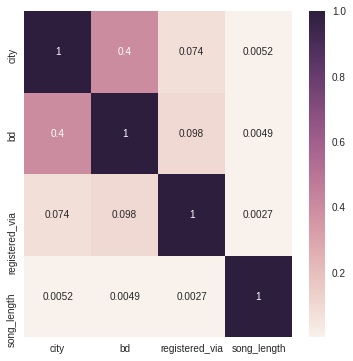

In [37]:
cor = df_train.corr()
plt.figure(figsize=(6,6))
sns.heatmap(cor,annot=True)

# Target variable distribution

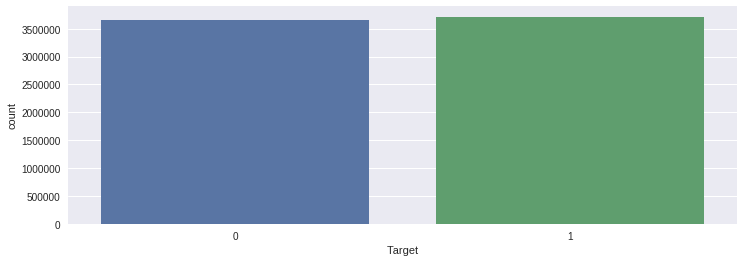

In [32]:
df_train['target'].nunique()
plt.figure(figsize=(12,4))
sns.countplot(df_train['target'])
plt.xlabel('Target')

# Date time feature

In [62]:
def date_feature(df):
    var = ['registration_init_time','expiration_date']
    k = ['reg','exp']
    df['sub_duration'] = (df[var[1]] - df[var[0]]).dt.days
    for i ,j in zip(var,k):
        df[j+'_day'] = df[i].dt.day
        df[j+'_weekday'] = df[i].dt.weekday        
        df[j+'_month'] = df[i].dt.month
        df[j+'_year'] =df[i].dt.year

date_feature(df_train)
date_feature(df_test)

In [63]:
def uniq(df):
    col = df.columns
    for i in col:
        print('\n Unique value of "{}" is "{}" '.format(i,df[i].nunique()))
        #print(df[i].unique())
uniq(df_train)


 Unique value of "msno" is "30755" 

 Unique value of "song_id" is "359966" 

 Unique value of "source_system_tab" is "9" 

 Unique value of "source_screen_name" is "20" 

 Unique value of "source_type" is "12" 

 Unique value of "target" is "2" 

 Unique value of "city" is "21" 

 Unique value of "bd" is "92" 

 Unique value of "gender" is "2" 

 Unique value of "registered_via" is "5" 

 Unique value of "registration_init_time" is "3811" 

 Unique value of "expiration_date" is "1395" 

 Unique value of "song_length" is "60266" 

 Unique value of "genre_ids" is "572" 

 Unique value of "artist_name" is "40582" 

 Unique value of "composer" is "76064" 

 Unique value of "lyricist" is "33889" 

 Unique value of "language" is "10" 

 Unique value of "sub_duration" is "4321" 

 Unique value of "reg_day" is "31" 

 Unique value of "reg_weekday" is "7" 

 Unique value of "reg_month" is "12" 

 Unique value of "reg_year" is "14" 

 Unique value of "exp_day" is "31" 

 Unique value of "exp_w

# Preprocessing 

In [64]:
df_train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length', 'genre_ids',
       'artist_name', 'composer', 'lyricist', 'language', 'sub_duration',
       'reg_day', 'reg_weekday', 'reg_month', 'reg_year', 'exp_day',
       'exp_weekday', 'exp_month', 'exp_year'],
      dtype='object')

# Encoder

In [65]:
le = LabelEncoder()
cat = ['source_system_tab','source_screen_name','source_type', 'gender',
       'genre_ids','artist_name','composer','lyricist','song_length','language']
def label(df,var):
    for i in var:
        df[i]= le.fit_transform(df[i])

In [66]:
label(df_train,cat)
label(df_test,cat)

# Split data set 

In [ ]:
unwanted = ['target','registration_init_time', 'expiration_date']
X = df_train.drop(unwanted,axis=1)
y = df_train['target']
x_test = df_test.drop(unwanted,axis=1)

# Predict for unsen data set

In [ ]:
y_pred = pred_test_full/2
submit = pd.DataFrame({'id':test['id'],'target':y_pred})
submit.to_csv('lr_porto.csv.gz',index=False,compression='gzip') 
#submit.to_csv('lr_porto.csv',index=False) 

In [ ]:
submit.head()

# Thank you for visiting